# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 7: Real World Classification Tradeoffs

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S7**</center>

In this section we will be covering real-world issues that arise with building classifiers. Specifically we will be discussing how to work with ROC curves, strategies to handle imbalanced datasets, and why the end metric that you’re actually interested in should be considered during model selection (i.e., you should think beyond just accuracy and classification statistics). 

Specifically, we will: 
    
    1. Apply and interpret an ROC curve on a logistic classifier on the Titanic Dataset 
    2. Fit a logistic regression model to a (simulated) dataset of past customer purchases, and see if we can predict whether they’re pregnant 
    3. Build a classifier to help a non-profit target their fund-raising mailing more effectively, and see how different models perform remarkable different on an estimated net-revenue basis, despite having similar overall accuracy metrics. 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics, datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Review ROC Curves (Titanic Example) 

Let’s start by load in the Titanic Dataset that we’ve become very familiar with over the last few sections, and fit a standard logistic regression classifier. 

In [2]:
import statsmodels.formula.api as sm
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# Subset to only cols we want
titanic = titanic[['sex', 'age', 'class', 'survived']]

# Rename 'class' col to 'pclass' to avoid namespace issues
titanic.columns = ['sex', 'age', 'pclass', 'survived']

#Drop any row with NA values in any col in dataframe
titanic = titanic.dropna()

is_female = pd.get_dummies(titanic.sex)['female']
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]

titanic_c = pd.concat([is_female,pclass_coded,titanic[['age','survived']]],axis=1)
titanic_c.head()

,female,First,Second,age,survived
0,0,0,0,22.0,0
1,1,1,0,38.0,1
2,1,0,0,26.0,1
3,1,1,0,35.0,1
4,0,0,0,35.0,0


In [4]:
logit = LogisticRegression(C=1000000)
train, test =  train_test_split(titanic_c, test_size=.2, random_state=123)
X_train = train.iloc[:,:4]
y_train = train.survived

X_test = test.iloc[:,:4]
y_test = test.survived

logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))

0.755244755245


Overall Accuracy is about 75%. Let’s fit an ROC curve…

In [5]:
logit.coef_

array([[ 2.66233164,  2.5962139 ,  1.13821077, -0.03594795]])

In [6]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")

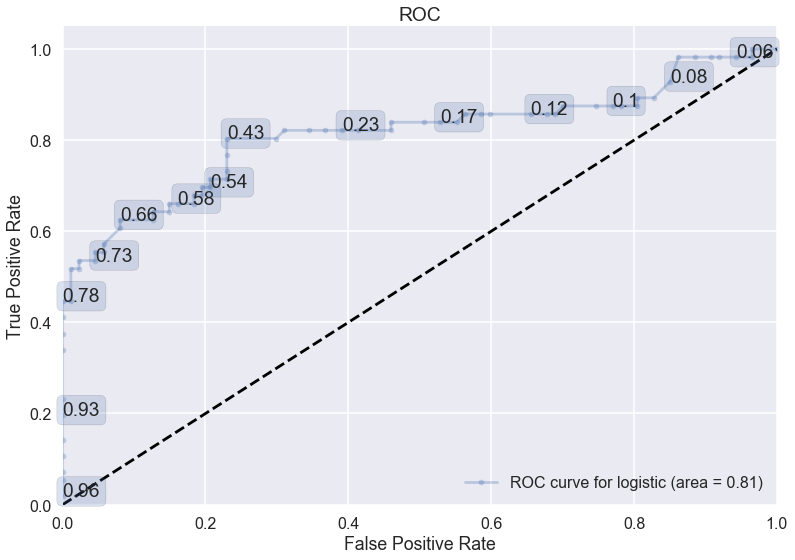

In [7]:
make_roc("logistic",logit, y_test,X_test)

What does the blue line actually mean in this scenario? How might our model be different if we were at a different position on the line? 

In [8]:
predicted = logit.predict(test[['female','First','Second','age']])
threshold = .5
#predicted = threshold < pd.DataFrame(logit.predict_proba(test[['female','First','Second','age']]))[1]
expected = test['survived']
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.80      0.79      0.80        87
          1       0.68      0.70      0.69        56

avg / total       0.76      0.76      0.76       143



In [9]:
pd.crosstab(expected,predicted,margins=True,dropna=False)

col_0,0,1,All
survived,,,
0,69,18,87
1,17,39,56
All,86,57,143


The row totals (87 died, 56 survived) above represent the *true* number of individuals in our test set that survived or perished on the titanic. The columns represent what our model predicted. Per the precision stats above, our model is getting about 3/4  of the test set correctly categorized, but still has a lot of false negatives and false positives.

However, we can play with the discretization threshold for different outcomes:

In [10]:
threshold = .75
predicted = threshold < pd.DataFrame(logit.predict_proba(test[['female','First','Second','age']]))[1]
expected = test['survived']
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.76      0.99      0.86        87
          1       0.97      0.52      0.67        56

avg / total       0.84      0.80      0.79       143



With this dataset, there’s probably no real reason we’d want to optimize for anything but overall accuracy. (So we’d want our classifier to be in the upper left-hand corner of the ROC curve.) In the next example the situation is quite different… 

---

## Review oversampling (Pregnancy prediction example) 

This dataset was adapted from an example in *Data Smart* by John Foreman. It's a dataset of indicator variables about customer purchases in the past six-months for a (simulated) large retailer. Ala the scandal that Target [experienced](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/#3ceb310b6668) a few years back, the question is, can you predict customer’s pregnancy status based on their purchases alone? 

Separate training and test samples (1000 observations each) are provided:

In [11]:
store_train = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_train.csv")
store_test = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_test.csv")
store_train.head()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [12]:
store_train.groupby("PREGNANT").count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500


In [13]:
store_test.groupby("PREGNANT").count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,940,940,940,940,940,940,940,940,940,940,940,940,940,940
1,60,60,60,60,60,60,60,60,60,60,60,60,60,60


Note that only ~4% of adult women are pregnant at any given time, so it’s a very imbalanced classification problem. However, we’ve significantly *oversampled* observations of pregnant women in our training data so as to ensure that our model does a good job of identifying true positives. What’s the downside of this approch? 

Anyway, let's build a logistic regression and evaluate the ROC curve...

In [14]:
logit = LogisticRegression(C=1000000)
X_train = store_train.iloc[:,:14]
y_train = store_train.PREGNANT

X_test = store_test.iloc[:,:14]
y_test = store_test.PREGNANT

logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))

0.887


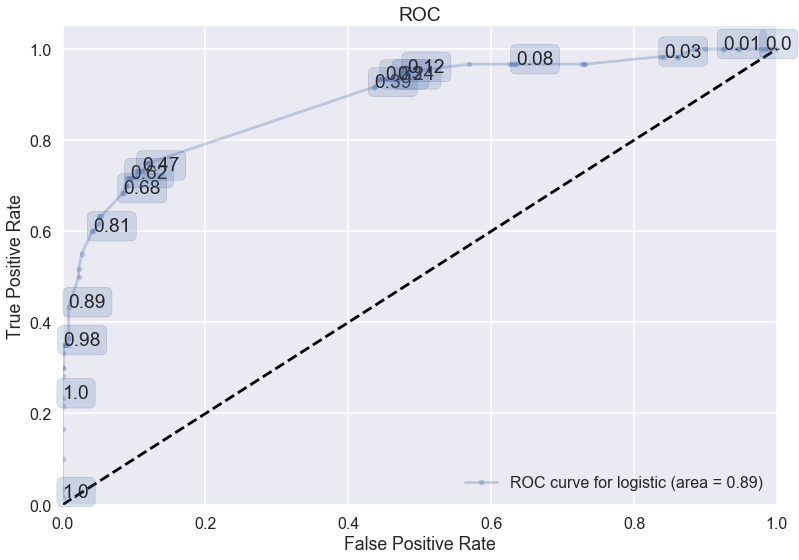

In [15]:
make_roc("logistic",logit, y_test,X_test)

In [16]:
predicted = logit.predict(X_test)
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.98      0.90      0.94       940
          1       0.31      0.73      0.44        60

avg / total       0.94      0.89      0.91      1000



In [17]:
pd.crosstab(y_test,predicted,margins=True,dropna=False)

col_0,0,1,All
PREGNANT,,,
0,843,97,940
1,16,44,60
All,859,141,1000


Note that while our model does a great job of identifying true-positives (pregnant women) it comes at the cost of increased false-positives. Depending on what we were actually going to do this data, we might prefer one or another, and build a model that chose a different optimum on the ROC curve. 

---

# Predicting Outcome of a Fund-raising Campaign

You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can identify which donors to mail in order to expected maximize net contribution, given the cost of mailing a flyer or package is \$7 per donor. 

In this section, we will cast this problem as a classification problem: we build a model to classify each individual as a mail-worthy donor (will likely donate more than \$7) or a un-mail-worthy donor (will likely donate less than \$7). Again, our goal is to maximize the expected net contribution.

The data is contained in the file `dataset.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

## Step 1: Clean and explore the data

First let's read and explore the data.

In [18]:
#Load and inspect the data
data = pd.read_csv('https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/dataset.txt', low_memory=False)  # low memory is set false for better type inference
data.head()

,OSOURCE,TCODE,STATE,MAILCODE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,...,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2,TARGET_D
0,BBK,2.0,MN,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,3.0,A,4.0
1,SYN,0.0,TX,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,14.0,A,7.0
2,DRK,0.0,IA,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,11.0,C,5.0
3,BHG,0.0,CA,_,0,_,_,_,_,XXXX,...,0.0,L,2.0,F,X,X,X,2.0,A,13.0
4,L01,1.0,GA,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,E,X,X,X,22.0,A,10.0


The entries in the dataframe that read `'_'` are missing values. They should be replaced with NaN before you decide what to do with them.

In [19]:
#Replace missing values with NaN
data = data.replace('_', np.nan)
data.head()

,OSOURCE,TCODE,STATE,MAILCODE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,...,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2,TARGET_D
0,BBK,2.0,MN,NaN,0,NaN,NaN,NaN,NaN,XXXX,...,1.0,L,3.0,D,X,X,X,3.0,A,4.0
1,SYN,0.0,TX,NaN,0,NaN,NaN,NaN,NaN,XXXX,...,1.0,L,3.0,D,X,X,X,14.0,A,7.0
2,DRK,0.0,IA,NaN,0,NaN,NaN,NaN,NaN,XXXX,...,1.0,L,3.0,D,X,X,X,11.0,C,5.0
3,BHG,0.0,CA,NaN,0,NaN,NaN,NaN,NaN,XXXX,...,0.0,L,2.0,F,X,X,X,2.0,A,13.0
4,L01,1.0,GA,NaN,0,NaN,NaN,NaN,NaN,XXXX,...,1.0,L,3.0,E,X,X,X,22.0,A,10.0


It looks like the NaN values appear only in a few columns. For the sake of expediency, we will simply drop the columns with missing values. **You might want to handle the missing data in a more sophisticated way**. (Such as on this week's HW...) 

In [20]:
#Remove columns with missing values

complete_cols = [column for column in data.columns if len(data[column][data[column].isnull()]) == 0]
        
data = data[complete_cols]

data.head()

,TCODE,STATE,NOEXCH,MDMAUD,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,TARGET_D
0,2.0,MN,0,XXXX,10.0,2.0,25.0,40.0,27.0,11.0,...,4.066667,1.0,L,3.0,D,X,X,X,3.0,4.0
1,0.0,TX,0,XXXX,0.0,1.0,37.0,58.0,16.0,8.0,...,6.181818,1.0,L,3.0,D,X,X,X,14.0,7.0
2,0.0,IA,0,XXXX,5.0,0.0,33.0,24.0,39.0,6.0,...,4.857143,1.0,L,3.0,D,X,X,X,11.0,5.0
3,0.0,CA,0,XXXX,0.0,0.0,34.0,20.0,54.0,2.0,...,11.000000,0.0,L,2.0,F,X,X,X,2.0,13.0
4,1.0,GA,0,XXXX,10.0,0.0,21.0,53.0,8.0,5.0,...,9.400000,1.0,L,3.0,E,X,X,X,22.0,10.0


We see that some of the predictors are categorical and some are quantitative. We need to convert the real-valued predictor values into floating points and encode the categorical variables as integers (we will furthre convert the categorical variables into binary variable using one-hot-encoding). To decide which variables are quantitative and which are categorical, you need to interpret the meaning of each predictor and use your common sense.

In [21]:
# Categoricals will be int or str (object), the rest float

# List of columns to be converted to floating point
to_float = ['HIT', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'NUMPRM12', 
           'CARDPM12', 'CARDPROM', 'NUMPROM', 'NGIFTALL', 'CARDGIFT']

# Converted columns to floating point
for feature_name in to_float:
    data[feature_name] = data[feature_name].astype(float)

# Columns between POP901 to AC2 should all be float
index1 = data.columns.get_loc("POP901")
index2 = data.columns.get_loc("AC2")

for i in range(index1, index2 + 1):
    data.iloc[:, i] = data.iloc[:, i].astype(float)

In [22]:
#Encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (data.dtypes.values != np.dtype('float64'))

# Encode all labels
data = data.apply(encode_categorical)

# Get numpy array from data
x = data.values[:, :-1]
y = data.values[:, -1]

# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

Let's split our dataset into train and test.

In [23]:
x_train, x_test, y_train_val, y_test_val = train_test_split(x, y, test_size=0.6, random_state=42)

Recall that the response variable, amount donated, is a real-valued variable not a binary variable! We need to convert the amount donated into a binary value: 0 for under \$7 and 1 for over \$7.

In [24]:
#Threshold for class 0
threshold = 7

y_train = np.copy(y_train_val)
y_test = np.copy(y_test_val)

y_train[y_train_val > threshold] = 1
y_train[y_train_val <= threshold] = 0

y_test[y_test_val > threshold] = 1
y_test[y_test_val <= threshold] = 0

cost_per_donor = 7

#Print some useful info for our test, train sets
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y_train[y_train == 0]), len(y_train[y_train == 1])))
print('test class 0: {}, test class 1: {}'.format(len(y_test[y_test == 0]), len(y_test[y_test == 1])))

train data:  (3571, 397)
test data:  (5357, 397)
train class 0: 2025, train class 1: 1546
test class 0: 3010, test class 1: 2347


---

## Step 2: Establish the Baseline Models (for Sanity Check)

What are the baseline models in this case? We can check off three basic models: 

1. a model that labels everything 1
2. a model that labels everything 0
3. a model that randomly guesses a label, 1 or 0

Before implementing anything fancy, let's implement these baseline models and see how they do.

**Note:** Again, think about accuracy in a **meaningful** way.

In [25]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [26]:
#A model that labels everything 1
class Pos_model(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
#A model that labels everything 0
class Neg_model(object):
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)


#A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [27]:
pos_model = Pos_model()
pos_model_scores = score(pos_model, x_test, y_test)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x_test, y_test)

random_model = Random_model()
random_model_scores = score(random_model, x_test, y_test)

In [28]:
#Score Dataframe
score_df = pd.DataFrame({'pos model': pos_model_scores,
                         'neg model': neg_model_scores,
                         'random model': random_model_scores})
score_df

,neg model,pos model,random model
overall accuracy,0.561882,0.438118,0.501400
accuracy on class 0,1.000000,0.000000,0.496346
accuracy on class 1,0.000000,1.000000,0.504900


---

## Step 3: Build Fancier Models

Now that we have an idea of how baseline models perform, let's try to improve upon them with fancier classifiers.

In [29]:
#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print('unweighted log')


#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score(weighted_logistic, x_test, y_test)
print('weighted log')

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)
print('lda')

#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score(qda, x_test, y_test)
print('qda')

#Decision Tree
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

tree_scores = score(tree, x_test, y_test)
print('tree')

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)

rf_scores = score(rf, x_test, y_test)

print('rf')

unweighted log
weighted log


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


lda
qda
tree
rf


In [30]:
#Score Dataframe
score_df = pd.DataFrame({#'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores})
score_df

,lda,qda,rf,tree,unweighted logistic,weighted logistic
overall accuracy,0.567855,0.517640,0.564868,0.566548,0.567855,0.553855
accuracy on class 0,0.657475,0.386047,0.752159,0.748505,0.650498,0.532558
accuracy on class 1,0.452919,0.686408,0.324670,0.333191,0.461866,0.581167


So which model is better? Which out-performs our baseline models? What does "better" mean anyways? 

To perform meaningful model selection, we have to remember our task! We've been asked to create a classifier that will maximize expected net contribution! While accuracy is a helpful metric, it is not clear, by looking at these numbers, which model will generate a greater expected net contribution!

---

## Step 4: Meaningful Model Evaluation

To meaningully assess the effecitveness of our models, we have to evaluate them according to the utility function that computes the expected net contribution.

In [31]:
#--------  expected_profit
# A function that computes the expected net contribution generated from a mailing scheme based on
# your classification of potential doners as mail-worthy or not mail-worthy
# Input: 
#      y_true_val (the true amount donated by each individual)
#      y_true (true class labels)
#      y_pred (predicted class labels)
# Returns: 
#      expected_profit (expected net contribution)

def expected_profit(y_true_val, y_true, y_pred):
    
    profit = []
    
    for i in range(5000):
    
        sample = np.random.choice(len(y_true_val), len(y_true_val))

        true_donations = y_true_val[sample]
        true_labels = y_true[sample]
        pred_labels = y_pred[sample]

        pred_donors = pred_labels > 0

        cost = (pred_donors).sum() * 7.

        donations = true_donations[pred_donors].sum()

        profit.append(donations - cost)
        
    expected_profit = np.mean(profit)
    
    return expected_profit

In the following, we implement a selection of classification models. You should try more (like KNN, SVM, logistic with polynomial decision boundaries etc.)!

In [32]:
profits = []

#Unweighted logistic regression
y_pred = unweighted_logistic.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('unweighted log')

#Weighted logistic regression
y_pred = weighted_logistic.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('weighted log')

#LDA
y_pred = lda.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('lda')

#QDA
y_pred = qda.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('qda')

#Decision Tree
y_pred = tree.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('tree')

#Random Forest
y_pred = rf.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('rf')

#Positive Baseline Model
y_pred = pos_model.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('pos baseline')

#Negative Baseline Model
y_pred = neg_model.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('neg baseline')

#Random Baseline Model
y_pred = random_model.predict(x_test)

profits.append(expected_profit(y_test_val, y_test, y_pred))

print('rand baseline')

#Total possible profit (if all predictions are accurate)
profits.append(expected_profit(y_test_val, y_test, y_test))

print('total possible profit')

unweighted log
weighted log
lda
qda
tree
rf
pos baseline
neg baseline
rand baseline
total possible profit


In [33]:
profits

[5472.1903499999999,
 6295.53485,
 5115.2113499999996,
 6345.9056459999993,
 3243.9690500000002,
 4486.5956339999993,
 8138.1257919999989,
 0.0,
 5035.9259499999989,
 26364.662236]

In [34]:
#Score Dataframe
score_df = pd.DataFrame(data=np.array(profits).reshape((1, len(profits))), index=['net contribution'], columns=['unweighted log', 'weighted log', 'lda', 'qda', 'tree', 'rf', 'pos', 'neg', 'random', 'max possible profit'])
score_df

,unweighted log,weighted log,lda,qda,tree,rf,pos,neg,random,max possible profit
net contribution,5472.19035,6295.53485,5115.21135,6345.905646,3243.96905,4486.595634,8138.125792,0.0,5035.92595,26364.662236


How did each model do - which is the best model? 

Compare the net contribution obtained from each model with the accuracy of each model. How is accuracy related to the net contribution? Is accuracy a good predictor of net contribution (meaning is accuracy a meaningful metric for evaluating our models)?

What can we do to improve the performance of our models?

---